<a href="https://colab.research.google.com/github/LeifMessinger/VideoAccelerometerSync/blob/main/PrototypeCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Input

In [2]:
# Enter filename for video
video_filename = "Phone_Test_02.mp4"

# Enter filename for sensor
sensor_filename = "Phone_Test_02.csv"

#Hit "Run All" and scroll to the bottom!

#It takes about 3x the length of your video to run the calculations.
#Future groups contributing to this might want to limit how much of the video is processed.

## Prototype code for the video sensor sync project

This program will process the accelerometer sensor data to calculate the magnitude of change of acceleration.

Then, video data will be processed to calculate the changes by frame.

Finally, cross-correaltion analysis will be performed on both signals and the lag will be identified.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy
import VidAccSyn
from math import ceil

Upload the files separately for processing

Currently expecting a .csv file for sensor and .mp4 file for video

Cross correlation will be performed to identify the lag between the signals

Upload the sensor data file first

# Sensor data processing

In [4]:
# Arlene wrote this part. Modified to use as a function
def process_sensor_data(filename, fieldnames):
  df_raw = pd.read_csv(filename)

  #expand the fieldnames from the input
  x_field, y_field, z_field = fieldnames

  delta_x = df_raw[x_field].diff().dropna()
  delta_y = df_raw[y_field].diff().dropna()
  delta_z = df_raw[z_field].diff().dropna()

  mag_changes_res = np.sqrt(delta_x ** 2 + delta_y ** 2 + delta_z **2 )

  #shows the changes
  plt.figure(figsize=(12, 4))
  plt.subplot(2, 1, 1)
  plt.plot(mag_changes_res, label='Sensor')
  #plt.plot(signal2, label='Signal 2')
  plt.legend()
  plt.show()

  return mag_changes_res

Process the sensor data file and show the magnitude of changes

Field names are defined here and passed into the function. The field names may be different on the actual data and will need to be modified here.

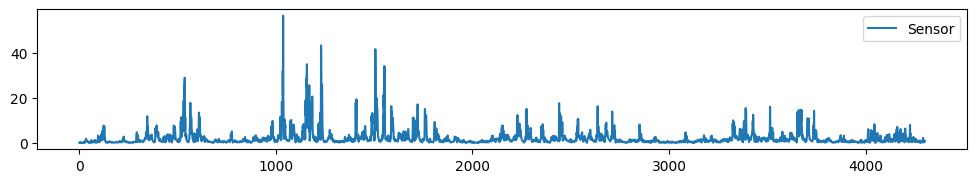

In [5]:
fieldnames =  'Linear Acceleration x (m/s^2)', 'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)'
processed_sensor_data = process_sensor_data(sensor_filename, fieldnames)

# Video file processing

The video_to_graph function reads in a video, calculates the difference between frames, and plots of graph of the differences.

In [6]:
# Code by Usha to process the video and calculate the difference between frames
def video_to_graph(video_path, threshold=30):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Read the first frame
    ret, prev_frame = cap.read()
    prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    frame_diffs = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the frame to grayscale
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calculate absolute difference between frames
        flow = cv2.calcOpticalFlowFarneback(prev_frame_gray, frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        average_flow_magnitude = np.mean(mag)

        frame_diffs.append(average_flow_magnitude)

        # Update the previous frame
        prev_frame_gray = frame_gray

    cap.release()

    frame_diffs = np.abs(np.gradient(frame_diffs)) #Gets the derivative

    # Plot the graph
    plt.plot(frame_diffs)
    ##plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.xlabel('Frame')
    plt.ylabel('Frame Difference')
    plt.title('Video Frame Differences')
    #plt.legend()
    plt.show()

    return frame_diffs


100%|█████████▉| 1288/1289 [05:58<00:00,  3.60it/s]


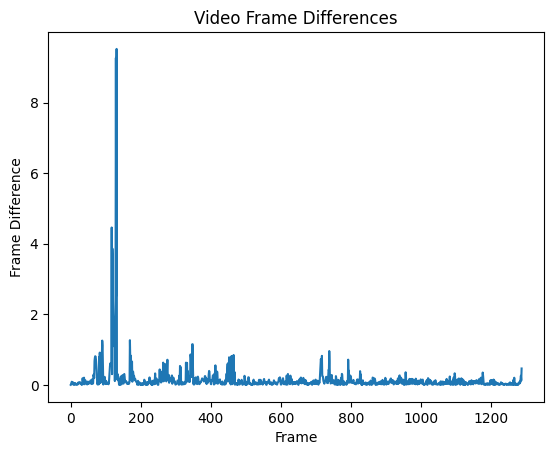

In [7]:
frame_diff = VidAccSyn.stdev_video_to_velocity(path=video_filename)
frame_diff = VidAccSyn.velocity_to_acceleration(frame_diff)

# Plot the graph
plt.plot(frame_diff)
##plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Frame')
plt.ylabel('Frame Difference')
plt.title('Video Frame Differences')
plt.show()

# Resampling

This is to ensure that both signals are of the same frequency to perform cross-correlation analysis

In [8]:
sensor_rate = 100       # Hz
sensor_len = 4.48088    # Seconds (of accelerometer)
video_rate = 30         # FPS
video_len = 7           # Seconds (of video)

# Finding downsampling rate by setting higher frequency to the lower frequency
max_rate = max(sensor_rate, video_rate)
min_rate = min(sensor_rate, video_rate)
downsampling = max_rate / min_rate

# Resampling higher frequency
if sensor_rate > video_rate:
    signal_rs = np.interp(np.arange(0, len(processed_sensor_data), downsampling), np.arange(len(processed_sensor_data)), processed_sensor_data)
    video_rs = frame_diff
elif sensor_rate < video_rate:
    signal_rs = processed_sensor_data
    video_rs = np.interp(np.arange(0, len(frame_diff), downsampling), np.arange(len(frame_diff)), frame_diff)

# Quick tests to check both signal's frequencies
print("Testing for original Hz values: ", len(processed_sensor_data)/sensor_len, len(frame_diff)/video_len)
print("Testing for new matching Hz values: ", len(signal_rs)/sensor_len, len(video_rs)/video_len)

# Padding to ensure same amount of data points (necessary for cross-correlation)
if len(video_rs) > len(signal_rs):
    signal_rs_new = np.pad(signal_rs, (0, len(video_rs) - len(signal_rs)))
    video_rs_new = video_rs
elif len(video_rs) < len(signal_rs):
    video_rs_new = np.pad(video_rs, (0, len(signal_rs) - len(video_rs)))
    signal_rs_new = signal_rs

# Getting resample size for the upcoming lag values
resample_size = 2 * len(signal_rs_new) - 1

Testing for original Hz values:  960.0792701433647 184.0
Testing for new matching Hz values:  288.11304922247416 184.0


# Cross-correlation Analysis

Perform cross correlation analysis and show the results.

In [9]:
# Originally code by Usha using cross correlation and finding the lag value. Updated to be a function.
def cross_correlation_analysis(signal1, signal2, labels):
  # Cross-correlation
  cross_correlation = scipy.signal.correlate(signal1, signal2, mode='full')
  cc = list(cross_correlation)

  # Finding lag
  lag = (cc.index(max(cc)) - len(signal1))
  lag_in_sec = lag / float(min_rate)

  # Plotting the original signals and showing alignment through the lag values
  fig, ax1 = plt.subplots()
  ax1.set_xlabel('Time (s)')
  ax1.set_ylabel('Sensor Acceleration', color = 'tab:red')
  ax1.plot((np.arange(len(signal1)) - lag)/min_rate, signal1, label = labels[0], color = 'tab:red')
  ax2 = ax1.twinx()
  ax2.set_ylabel('Video Acceleration', color = 'tab:blue')
  ax2.plot(np.arange(len(signal1))/min_rate, signal2, label = labels[1], color = 'tab:blue')
  fig.tight_layout()
  plt.show()

  # Lag (x-axis) values for cross-correlation graph
  lag_arr = (np.arange((-1* resample_size/2), resample_size/2) + 1) / float(min_rate)

  # Plotting cross-correlation graph
  plt.subplot(2, 1, 2)
  print(lag_arr.shape, cross_correlation.shape)
  plt.plot(lag_arr, cross_correlation)
  plt.title('Cross-correlation')
  plt.xlabel('Lag (s)')
  plt.ylabel('Correlation')
  plt.tight_layout()
  plt.show()

  # Returning cross-correlation matrix along with amount of lag (in seconds)
  return cross_correlation, lag_in_sec

# Results

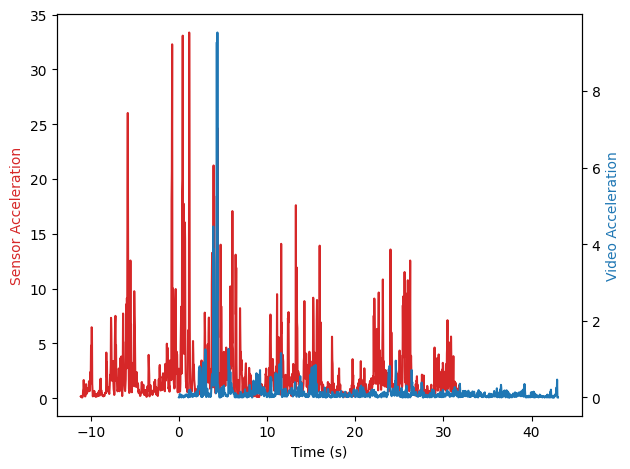

(2581,) (2581,)


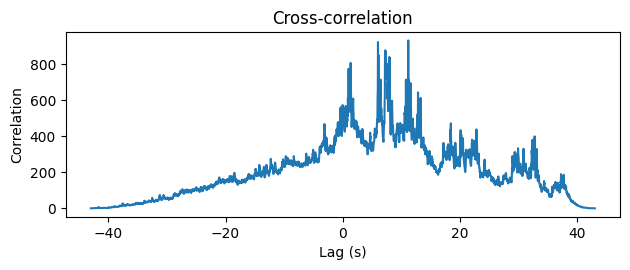

In [10]:
cc, lag_in_sec = cross_correlation_analysis(signal_rs_new, video_rs_new, ['sensor', 'video'])

In [11]:
if lag_in_sec < 0:
    print(f'The sensor started ~{abs(lag_in_sec):.3} seconds after the video.')
elif lag_in_sec > 0:
    print(f'The video started ~{abs(lag_in_sec):.3} seconds after the sensor.')

The video started ~11.1 seconds after the sensor.


## Again, but with log scaling

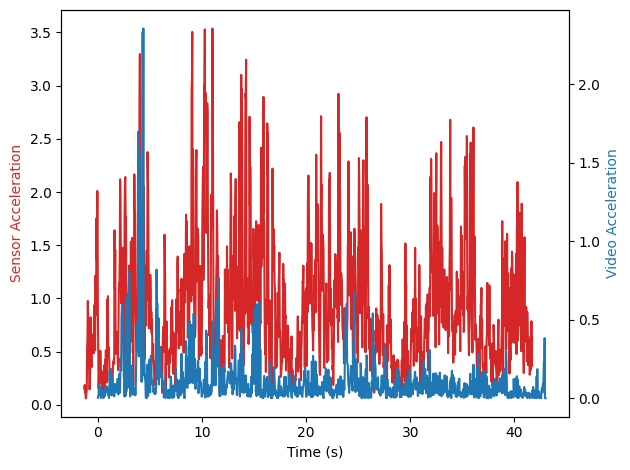

(2581,) (2581,)


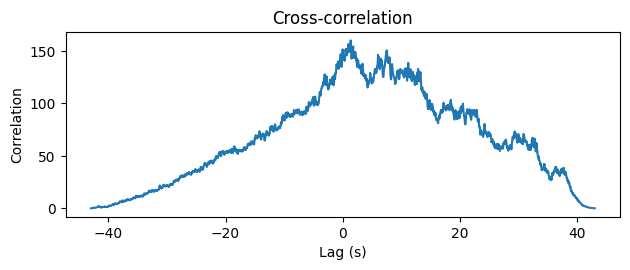

In [12]:
signal_rs_new = np.log1p(signal_rs_new)
video_rs_new = np.log1p(video_rs_new)

cc, lag_in_sec = cross_correlation_analysis(signal_rs_new, video_rs_new, ['sensor', 'video'])

In [13]:
if lag_in_sec < 0:
    print(f'The sensor started ~{abs(lag_in_sec):.3} seconds after the video.')
elif lag_in_sec > 0:
    print(f'The video started ~{abs(lag_in_sec):.3} seconds after the sensor.')

The video started ~1.3 seconds after the sensor.
